In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.style.use("ggplot")

from src.alternatingLeastSquares import ALS

from src.plottingFunctions import plotALSResults

In [2]:
jokes_df = pd.read_excel("jokes_dataset.xls", header=None, usecols=range(1, 151))
jokes_df = jokes_df.replace(99, np.nan)
R = jokes_df.to_numpy()

In [3]:
def filter_rows_by_threshold(R, lower_threshold_pct, upper_threshold_pct):
    num_items = R.shape[1]
    user_ratings = np.sum(~np.isnan(R), axis=1) / num_items

    users_to_remove = np.where(
        (user_ratings < lower_threshold_pct) | (user_ratings > upper_threshold_pct)
    )[0]

    filtered_R = np.delete(R, users_to_remove, axis=0)

    return filtered_R


def filter_columns_by_threshold(R, lower_threshold_pct, upper_threshold_pct):
    num_users = R.shape[0]
    item_ratings = np.sum(~np.isnan(R), axis=0) / num_users

    items_to_remove = np.where(
        (item_ratings < lower_threshold_pct) | (item_ratings > upper_threshold_pct)
    )[0]

    filtered_R = np.delete(R, items_to_remove, axis=1)

    return filtered_R


lower_threshold_pct = 0.05  # Remove users with less than 10% of total ratings
upper_threshold_pct = 0.9  # Remove users with more than 90% of total ratings
filtered_R = filter_columns_by_threshold(R, lower_threshold_pct, upper_threshold_pct)
print(filtered_R.shape)

lower_threshold_pct = 0.4  # Remove users with less than 10% of total ratings
upper_threshold_pct = 0.6  # Remove users with more than 90% of total ratings
filtered_R = filter_rows_by_threshold(
    filtered_R, lower_threshold_pct, upper_threshold_pct
)
print(filtered_R.shape)

(54905, 120)
(3605, 120)


In [4]:
print(R.shape)
print(f"{round((np.count_nonzero(~np.isnan(R))/R.size)*100,2)}% of full entries")

(54905, 150)
22.37% of full entries


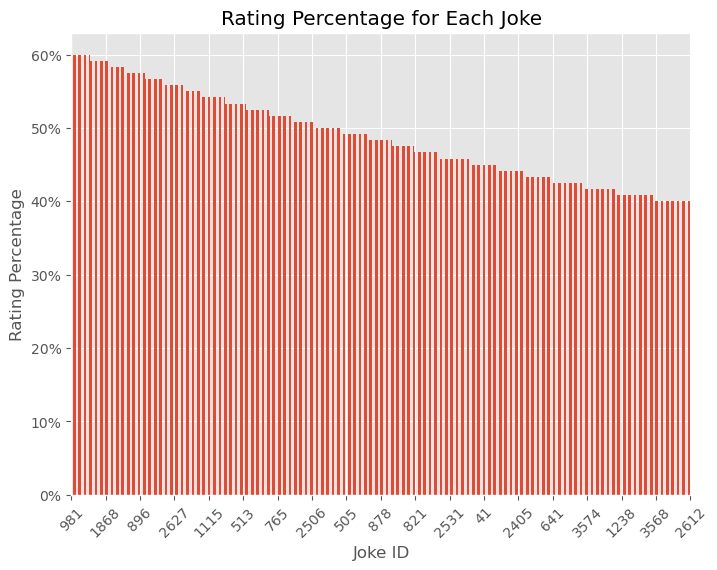

In [5]:
df = pd.DataFrame(filtered_R)
rating_percentage = df.count(axis=1) / len(df.columns)

# Sort jokes by rating percentage in descending order
rating_percentage_sorted = rating_percentage.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
rating_percentage_sorted.plot(kind="bar")
plt.ylabel("Rating Percentage")
plt.xlabel("Joke ID")
plt.title("Rating Percentage for Each Joke")

# Modify x-ticks
n = 200  # Show every nth x-tick, adjust as needed
plt.xticks(
    range(0, len(rating_percentage_sorted), n),
    rating_percentage_sorted.index[::n],
    rotation=45,
)  # Rotate labels for better readability

# Modify y-ticks to show percentage
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.show()


In [6]:
R = filtered_R
mean = np.nanmean(R)
std = np.nanstd(R)
print(mean)
print(std)
normR = (R - mean) / std

2.6179835629720594
4.909671276985355


In [44]:
np.random.seed(43)
f = 200
alternations = 100
tol = 1e-5
max_iter = 100
lambQ = 0
lambP = lambQ

als_result = ALS(
    normR,
    f,
    alternations=alternations,
    tol=tol,
    max_iter=max_iter,
    lambQ=lambQ,
    lambP=lambP,
)


 Optimizing Q
 Oprimizing P
Alternations Completed: 1
 Optimizing Q
 Oprimizing P
Alternations Completed: 2
 Optimizing Q
 Oprimizing P
Alternations Completed: 3
 Optimizing Q
 Oprimizing P
Alternations Completed: 4
 Optimizing Q
 Oprimizing P
Alternations Completed: 5
 Optimizing Q
 Oprimizing P
Alternations Completed: 6
 Optimizing Q
 Oprimizing P
Alternations Completed: 7
 Optimizing Q
 Oprimizing P
Alternations Completed: 8
 Optimizing Q
 Oprimizing P
Alternations Completed: 9
 Optimizing Q
 Oprimizing P
Alternations Completed: 10
 Optimizing Q
 Oprimizing P
Alternations Completed: 11
 Optimizing Q
 Oprimizing P
Alternations Completed: 12
 Optimizing Q
 Oprimizing P
Alternations Completed: 13
 Optimizing Q
 Oprimizing P
Alternations Completed: 14
 Optimizing Q
 Oprimizing P
Alternations Completed: 15
 Optimizing Q
 Oprimizing P
Alternations Completed: 16
 Optimizing Q
 Oprimizing P
Alternations Completed: 17
 Optimizing Q
 Oprimizing P
Alternations Completed: 18
 Optimizing Q
 Opri

In [47]:
Ju_values = als_result["Ju_values"]
Ja_values = als_result["Ja_values"]
RMSEu_values = als_result["RMSEu_values"]
RMSEa_values = als_result["RMSEa_values"]
newQ = als_result["Q"]
newP = als_result["P"]


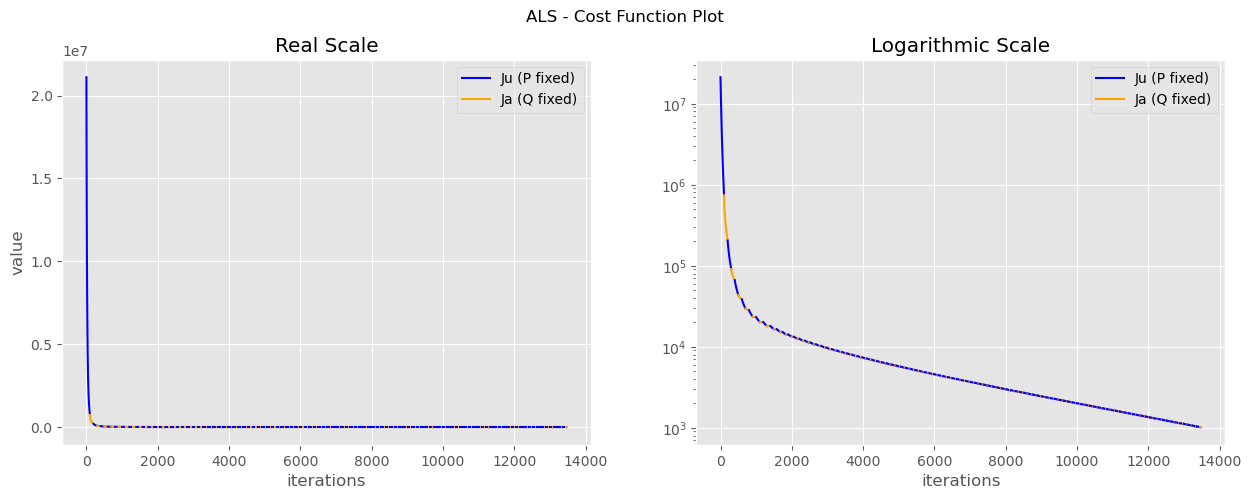

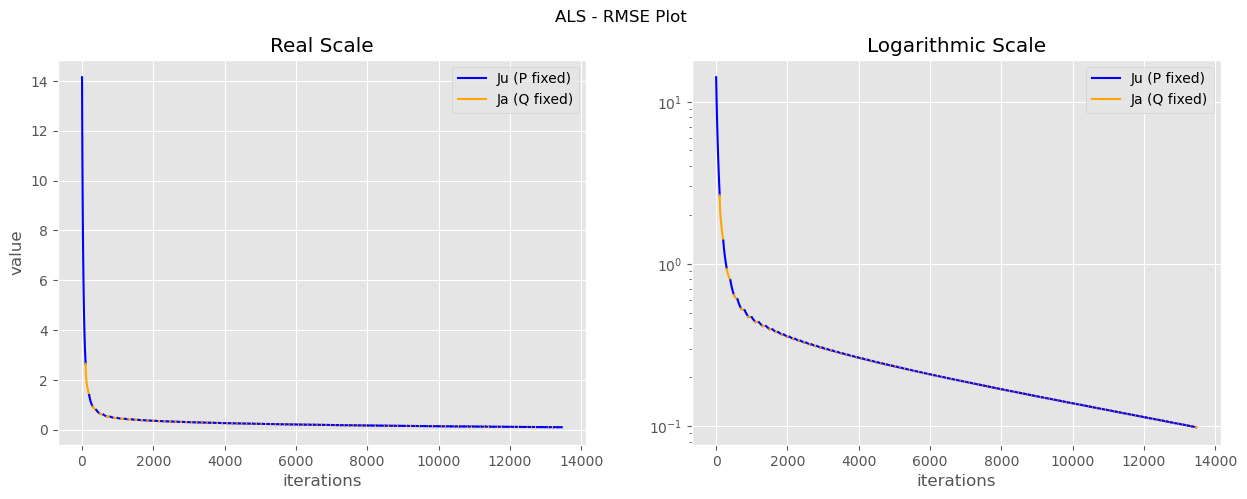

In [48]:
plotALSResults(Ju_values, Ja_values, "ALS - Cost Function Plot")
plotALSResults(RMSEu_values, RMSEa_values, "ALS - RMSE Plot")


In [49]:
print(len(Ju_values))
print(Ju_values[0][0])
print(Ja_values[-1][-1])


100
21103365.123376172
1016.2056213804839


In [50]:
import numpy as np

newR = (newQ @ newP.T) * std + mean

# Assume you have the 2D numpy arrays 'R' and 'Rnew' with NaN entries

# Mask for non-NaN entries in R
non_nan_mask = np.logical_not(np.isnan(R))

# Mask for positive recommendations in Rnew
positive_recommendations = np.logical_and(newR > 0, non_nan_mask)

# True positives
true_positives = np.logical_and(positive_recommendations, R > 0).sum()

# True negatives
true_negatives = np.logical_and(~positive_recommendations, R <= 0).sum()

# False positives
false_positives = np.logical_and(positive_recommendations, R <= 0).sum()

# False negatives
false_negatives = np.logical_and(~positive_recommendations, R > 0).sum()

# Accuracy
accuracy = (true_positives + true_negatives) / (
    true_positives + true_negatives + false_positives + false_negatives
)

# Precision
precision = true_positives / (true_positives + false_positives)

# Recall (also known as sensitivity or true positive rate)
recall = true_positives / (true_positives + false_negatives)

# F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9855009933099743
Precision: 0.9889945869767144
Recall: 0.9913951980067682
F1 Score: 0.9901934374919829


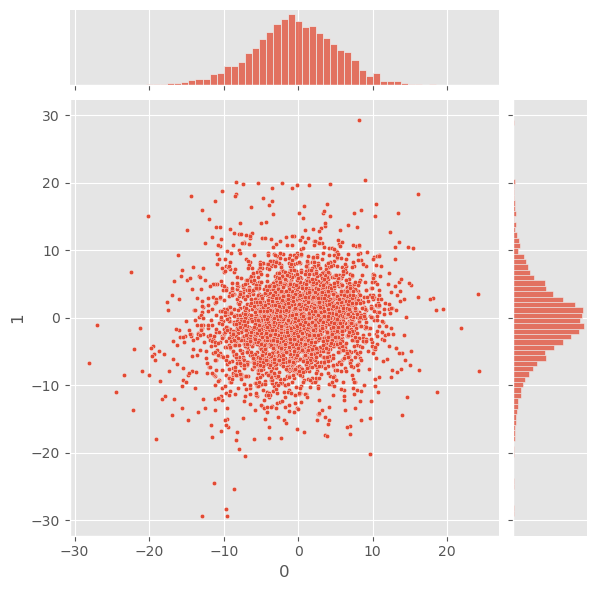

array([355.58807156, 331.97554221, 332.46562369, 323.4745422 ,
       322.64466654, 400.43652174, 335.54475516, 347.61286665,
       366.67928528, 345.21967092, 335.16631093, 395.69796382,
       361.46972908, 316.7142962 , 386.11949897, 363.61083203,
       347.91920283, 515.13408521, 334.15658421, 335.29596255])

In [48]:
newQ.shape
# Create a DataFrame for the matrix Q
df = pd.DataFrame(newQ)
sns.jointplot(data=df, x=0, y=1, kind="scatter", joint_kws={"s": 10})
plt.show()
euclidean_norms = np.linalg.norm(newQ, axis=0)
euclidean_norms


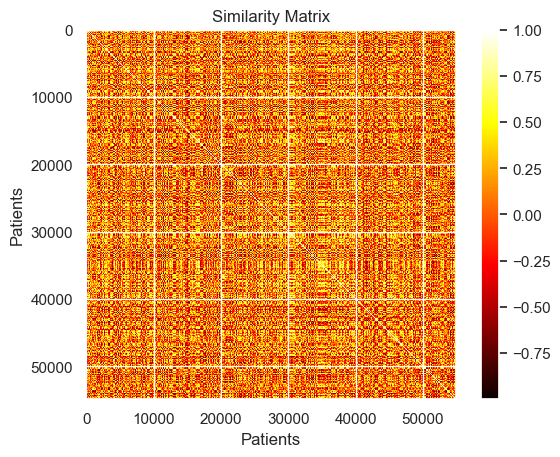

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import numpy as np

# Your matrix Q of latent factors
# For demonstration, let's assume it's a 5x5 matrix
Q = newQ

sampled_users_indices = np.random.choice(Q.shape[0], size=1000, replace=False)
Q = Q[sampled_users_indices, :]

# Calculate cosine similarity matrix
S = cosine_similarity(Q)

# Plot the similarity matrix as a heatmap
plt.imshow(S, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Similarity Matrix")
plt.xlabel("Patients")
plt.ylabel("Patients")
plt.show()


In [11]:
np.mean(S)

0.07353295107317775

In [12]:
# Flatten the similarity matrix into a 1D array
S_flatten = S.flatten()

# Plot the kernel density estimation
sns.kdeplot(S_flatten)
plt.title("Kernel Density Estimation of Similarity Values")
plt.xlabel("Similarity")
plt.ylabel("Density")
plt.show()


In [ ]:
# Perform hierarchical clustering
# Here, n_clusters is the number of clusters you want to create
n_clusters = 10
clustering = AgglomerativeClustering(
    n_clusters=n_clusters, metric="precomputed", linkage="average"
).fit(S)

# Print cluster labels for each patient
print(clustering.labels_)

# Draw the corresponding dendrogram
Z = hierarchy.linkage(S, "average")
plt.figure()
dn = hierarchy.dendrogram(Z)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your similarity matrix
similarity_matrix = np.random.rand(5, 5)  # Replace with your actual similarity matrix

# Plot the similarity matrix as a heatmap
plt.imshow(similarity_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Similarity Matrix")
plt.xlabel("Patients")
plt.ylabel("Patients")
plt.show()


In [119]:
print(pca.explained_variance_ratio_)

[0.0224319  0.02174767]


In [120]:
sum(pca.explained_variance_)

8.868554125496507

In [34]:
# Get the covariance matrix
covariance_matrix = pca.get_covariance()

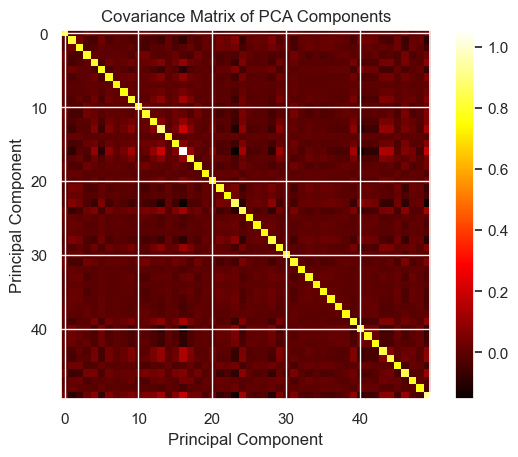

In [35]:
# Visualize the covariance matrix
plt.imshow(covariance_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix of PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Principal Component")
plt.show()


In [112]:
import numpy as np

# Assume you have the matrix Q with shape (m, f)

# Compute the mean of each column
mean_vector = np.mean(newP, axis=0)

# Subtract the mean from each column to center the data
centered_data = newP - mean_vector

# Compute the covariance matrix
covariance_matrix = np.cov(centered_data, rowvar=False)

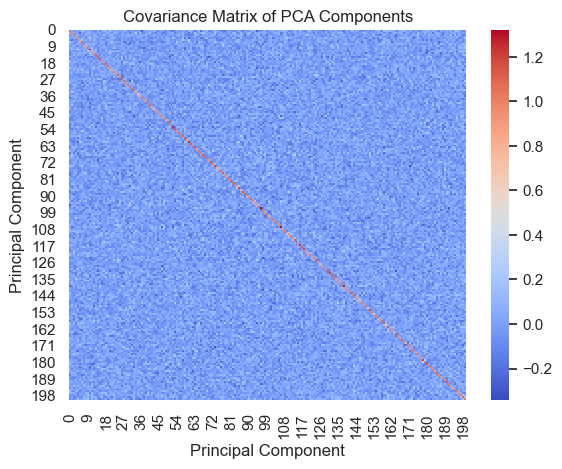

In [113]:
# Visualize the covariance matrix
sns.heatmap(covariance_matrix, cmap="coolwarm", fmt=".2f")
plt.title("Covariance Matrix of PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Principal Component")
plt.show()


In [15]:
newQ.shape

(54904, 2)

In [114]:
pca.explained_variance_

array([1.04135884, 1.03171959])

In [56]:
pca.explained_variance_ratio_

array([0.02772542, 0.0144743 ])

In [116]:
newP.shape

(150, 200)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
import numpy as np

# Your matrix Q of latent factors
# For demonstration, let's assume it's a 5x5 matrix
Q = newQ

# Calculate cosine similarity matrix
S = cosine_similarity(Q)

# Perform spectral clustering
# Here, n_clusters is the number of clusters you want to create
# This should be chosen based on domain knowledge or using methods like the Elbow method
n_clusters = 2
clustering = SpectralClustering(
    n_clusters=n_clusters, affinity="precomputed", random_state=0
).fit(S)

# Print cluster labels for each patient
print(clustering.labels_)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
Q_pca = pca.fit_transform(Q)

# Plot each patient, colored by cluster label
plt.figure(figsize=(10, 7))
plt.scatter(Q_pca[:, 0], Q_pca[:, 1], c=clustering.labels_, cmap="viridis")

plt.title("Patient Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.show()
